# <center>Image segmentation using SegNet and U-Net</center>

## 1. Intro

In this paper, we present some networks for processing dermoscopic images intended for computer-aided diagnosis of melanoma. The goal of the assignment is not to maximize accuracy, score etc., but to compare models performance and find loss function dependencies, if any. It is known that traditional FCNs rely on thousands of images for analysis, but we will try to show that it is possible to build networks that can give satisfactory results on a very few images. So, we'll try 2 networks: SegNet and U-Net. SegNet is a fully convolutional neural network for semantic pixel-wise segmentation, and U-Net is a convolutional neural network that was developed for biomedical image segmentation. It is worth to note that U-Net architecture was modified to work with fewer training images and to yield more precise segmentations. Besides we'll check different loss functions and compare networks performance depending of the loss selected.

## 2. Prerequisites
---


As an input data we'll use dataset [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>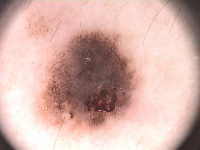</td><td>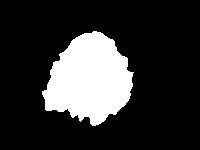</td></tr></table>

This image database contains a total of 200 dermoscopic images of melanocytic lesions, including 80 common nevi, 80 atypical nevi, and 40 melanomas. The PH² database includes medical annotation of all the images namely medical segmentation of the lesion, clinical and histological diagnosis and the assessment of several dermoscopic criteria (colors; pigment network; dots/globules; streaks; regression areas; blue-whitish veil).

We recall that this assignment purpose is not to classify images, but to **segment** them.

First of all, import necessary modules, define random seed and GPU device (if available). Then we'll download an archive with the dataset, extract the data and split them into train, validation and test parts that will be put in PyTorch dataloader.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import gc

from time import time
from skimage.io import imread
from skimage.transform import resize
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from matplotlib import colors, pyplot as plt, rcParams
%matplotlib inline

from os.path import exists
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

warnings.filterwarnings(action='ignore', category=DeprecationWarning)
gc.collect()
rcParams['figure.figsize'] = (15,4)

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()
device

device(type='cuda')

In [4]:
# !wget -c https://www.dropbox.com/s/n01pfz8911vn4q1/PH2Dataset.rar

In [5]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

The dataset has the following structure:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 where `X.bmp` is an image to be segmented, and `X_lesion.bmp` is a segmentation result.
 
 
We'll define the code to load and transform all images into specific size, and split the dataset into train, validation and test parts.

In [6]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Dataset images have different sizes, so resize them with [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) function that normalize images in range $[0,1]$ automatically.

In [7]:
# size = (256, 256)
size = (128, 128)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [9]:
len(lesions)

200

Now plot some of the images from the dataset to see how they look like:

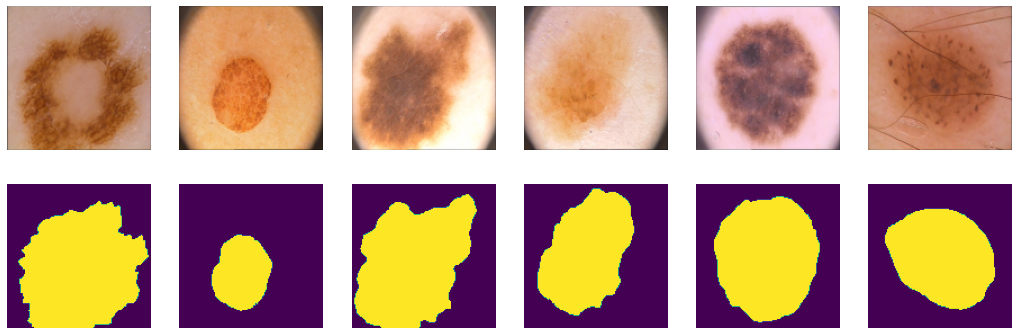

In [10]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [11]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

We will also need dataloaders to feed the data into our neural network.

In [13]:
batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True, num_workers=12)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True, num_workers=12)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True, num_workers=12)

## 3. Define losses and score

### 3.1. Metrics

In this section the following metric is used to assess quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

This metric is known as an Intersection over Union which is a kind of evaluation metrics.

The intersection (A ∩ B) consists of pixels found in both the prediction mask and the ground truth mask, while the union (A ∪ B) consists of all the pixels found in either the prediction mask or the target mask.


Let's look at the ground truth bounding box (left) and the predicted one (right):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then Intersection over Union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

An Intersection over Union score > 0.5 is normally considered a "good" prediction.

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds
    return thresholded  # 

### 3.2. Losses

Typically a loss function is used for parameter estimation, and the event in question is some function of the difference between estimated and true values for an instance of data. An optimization problem seeks to minimize a loss function. Many loss functions can be used to solve a binary semantic segmentation problem. 

In this paper, an experimental evaluation of 3 loss functions will be conducted: binary cross-entropy loss, Dice loss and focal loss.

#### 3.2.1. BCE loss (1 point)

*Binary cross-entropy* looks like this:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is the label(target result) and $\hat y$ is the model output (the predicted probablity). $\sigma$ is a  [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) transforming some real value $\mathbb R$ to probability $[0,1]$.

Note that BCE loss function is prone to the numerical instability. This [article](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) offers some useful simplifications of the base expression which ensure stability and prevent overflow in $\exp(y)$:

1. $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$


2. $$\mathcal L_{BCE} = max(\hat y, 0) - y\hat y + \log\left(1+\exp(-abs(\hat y))\right).$$

In [15]:
def bce_loss(y_real, y_pred):
    # loss = y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
    loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))    
    return loss.mean()

To ensure the custom BCE loss is correct we compare its result with PyTorch BCE function result:

In [16]:
test_tens_1 = torch.randn(100, 3, 128, 128)
test_tens_2 = torch.randn(100, 3, 128, 128)
print(nn.BCEWithLogitsLoss()(test_tens_1, test_tens_2), bce_loss(test_tens_1, test_tens_2))

tensor(0.8059) tensor(0.8066)


#### 3.2.2. Additional loss functions (2 points)

 This section considers two additional loss functions: DICE и Focal loss. 

**1. Dice coefficient:**

The common metric for measuring distance between $X$ and $Y$ looks like this:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it can be approximated with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2X_iY_i}{\sum_i(X_i+Y_i)}.$$

We can assume that Dice loss would give better results over BCE as it considers the loss information both locally and globally, while BCE only considers loss in a micro sense, which is not enough for image level prediction.

In [17]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = torch.sigmoid(y_pred)
    num = torch.sum(2*y_pred*y_real) + SMOOTH
    den = torch.sum(y_pred + y_real) + SMOOTH
    res = 1 - num/den
    return res 

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

As noted above, the BCE loss function has the following form:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

This loss however tends to benefit the **majority** (background) class relative to the **minority** (foreground) class. That's why weighting factors are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally the weight $\alpha_i$ is defined as the inverse frequency of the pixel class $i$, so the minority class observations weigh more relative to the majority class.

So, *Focal loss* adds a factor $(1-\hat y_i)^\gamma$ to the cross-entropy criterion and if $\gamma$ > 0, the function more focuses on misclassified examples rather than on well-classified examples.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

We'll use $\gamma = 2$.

--------------------------------------------------------------------------------


In [18]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    sigm = torch.sigmoid(y_pred)
    loss = eps*(1 - sigm)**gamma * y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
   
    return loss.mean()

### 3.3. Train (1 point)

Define a train function with an optimizer Adam and a scheduler. This function will be used with all models. 

In [19]:
def train(model, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    opt = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.6)
    duration = 0
    history = {
        'Epoch': list(range(1, epochs+1)),
        'Duration': None,
        'Train IoU': [],
        'Val IoU': [],
        'Train loss': [],
        'Val loss': []
    }

    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_score = 0
        avg_loss_val = 0
        avg_score_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device) # data to device
            Y_batch = Y_batch.to(device)

            opt.zero_grad() # set parameter gradients to zero

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            score = iou_pytorch(torch.sigmoid(Y_pred) > 0.5, Y_batch).mean().item()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_score += score / len(data_tr)
            
        toc = time()
        duration += toc - tic
        print('loss: %f' % avg_loss)
               
        scheduler.step()
        
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to("cpu" )# detach and put into cpu
        loss_val = loss

        # Visualize tools
        clear_output(wait=True)
        
        for X_val_batch, Y_val_batch in data_val:
            X_val_batch = X_val_batch.to(device)
            Y_val_batch = Y_val_batch.to(device)
            Y_pred_val = model(X_val_batch)
            loss_val = loss_fn(Y_val_batch, Y_pred_val)
            score_val = iou_pytorch(torch.sigmoid(Y_pred_val) > 0.5, Y_val_batch).mean().item()
            avg_loss_val += loss_val / len(data_val)
            avg_score_val += score_val/ len(data_val)
           
        history['Train IoU'].append(avg_score)
        history['Val IoU'].append(avg_score_val)
        history['Train loss'].append(avg_loss.item())
        history['Val loss'].append(avg_loss_val.item())
        
        fig, ax = plt.subplots(3, 6, figsize=(11, 9))
    
        for v in range(6):
            ax[0, v].imshow(np.rollaxis(X_val[v].numpy(), 0, 3), cmap='gray')
            ax[0, v].set_title('Real')
            ax[0, v].axis('off')

            ax[1, v].imshow(torch.sigmoid(Y_hat[v, 0]) > 0.5, cmap='gray')
            ax[1, v].set_title('Prediction')
            ax[1, v].axis('off')
            
            ax[2, v].imshow(Y_val[v, 0], cmap='gray')
            ax[2, v].set_title('Ground truth')
            ax[2, v].axis('off')
                      
        plt.suptitle('%d / %d - train_loss: %f , val_loss: %f, train_IoU: %f, val_IoU: %f' % (epoch+1, epochs, avg_loss, avg_loss_val, avg_score, avg_score_val))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.2)
        plt.show()    
    
    history['Duration'] = duration
    Y_batch.to("cpu")
    X_val_batch.to("cpu")
    Y_val_batch.to("cpu")
    del model
    del X_batch
    del Y_batch
    del X_val_batch
    del Y_val_batch
    torch.cuda.empty_cache()
    gc.collect()
    
    return history

### 3.4. Inference (1 point)

Here we define functions for score calculation (using IoU metric), logs plotting and GPU memory clearing.

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    
    return scores/len(data)

In [21]:
def plot_log(history, model_name, loss_name):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    score_train, score_val, loss_train, loss_val = history['Train IoU'], history['Val IoU'], history['Train loss'], history['Val loss']
    x = history['Epoch']
    
    ax[0].plot(x, loss_train, label = "train")
    ax[0].plot(x, loss_val, label = "val")
    ax[0].legend(fontsize = 14)
    ax[0].set_xlabel("epoch", fontsize = 14)
    ax[0].set_ylabel("loss", fontsize = 14)
    ax[0].set_title("Loss", fontsize = 16)

    ax[1].plot(x, score_train, label = "train")
    ax[1].plot(x, score_val, label = "val")
    ax[1].legend(fontsize = 14)
    ax[1].set_xlabel("epoch", fontsize = 14)
    ax[1].set_ylabel("IoU", fontsize = 14)
    ax[1].set_title("IoU result", fontsize = 16)

    plt.suptitle(f"{model_name} with {loss_name}", fontsize = 18)
    plt.tight_layout()
    plt.show()

In [22]:
def clear_gpu(model):
    model.to('cpu')
    del model
    torch.cuda.empty_cache()
    gc.collect()

-----------------------------------------------------------------------------------------

## 4. Different architectures implementation



### 4.1. SegNet (2 points)

The simplest encoder-decoder architecture is called SegNet. It uses standard CNN with convolutions and poolings in the encoder, and deconvolution CNN that includes convolutions and upsamplings in decoder. It also relies on batch normalization to train multi-layered network successfully.

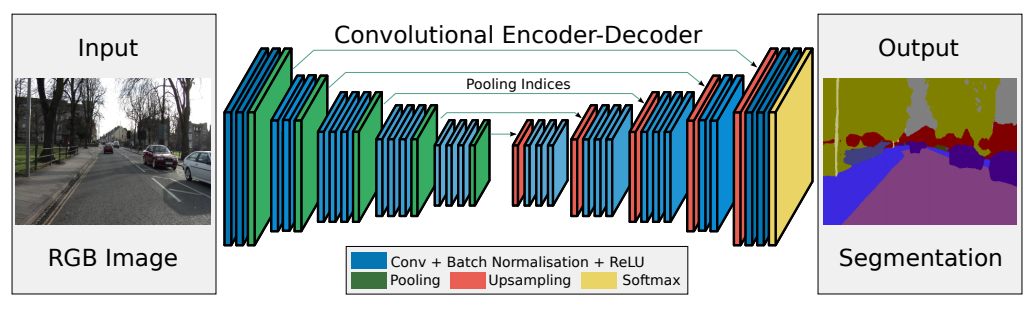

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Next, in addition to the main SegNet class, we will also define an auxiliary class EncDec, instances of which will act as building blocks consisting of convolution, batch normalization and activation function.

In [23]:
class EncDec(nn.Module):
    def __init__(self, in_channels, filters, kernel_size, padding):
        super().__init__()
        
        self.module = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(num_features=filters),
            nn.ReLU()
        )
    
    def forward(self, inputs):
        return self.module(inputs)
    
    
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel, padding, pooling = 3, 1, 2
        inp, outp, channels = 3, 1, 64
        
        self.enc_conv0 = nn.Sequential(
            EncDec(inp, channels, kernel, padding),
            EncDec(channels, channels, kernel, padding)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            EncDec(channels, channels*2, kernel, padding),
            EncDec(channels*2, channels*2, kernel, padding)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            EncDec(channels*2, channels*4, kernel, padding),
            EncDec(channels*4, channels*4, kernel, padding),
            EncDec(channels*4, channels*4, kernel, padding)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            EncDec(channels*4, channels*8, kernel, padding),
            EncDec(channels*8, channels*8, kernel, padding),
            EncDec(channels*8, channels*8, kernel, padding)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            EncDec(channels*8, channels*8, kernel, padding),
            EncDec(channels*8, channels*8, kernel, padding),
            EncDec(channels*8, channels*8, kernel, padding)
        )
               

        # decoder (upsampling)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=pooling, stride=pooling) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            EncDec(channels*8, channels*8, kernel, padding),
            EncDec(channels*8, channels*8, kernel, padding),
            EncDec(channels*8, channels*4, kernel, padding)
        )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=pooling, stride=pooling) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            EncDec(channels*4, channels*4, kernel, padding),
            EncDec(channels*4, channels*4, kernel, padding),
            EncDec(channels*4, channels*2, kernel, padding)
        )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=pooling, stride=pooling) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            EncDec(channels*2, channels*2, kernel, padding),
            EncDec(channels*2, channels, kernel, padding)
        )
        
        self.upsample0 = nn.MaxUnpool2d(kernel_size=pooling, stride=pooling) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            EncDec(channels, channels, kernel, padding),
            
            nn.Conv2d(in_channels=channels, out_channels=outp, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_features=outp) 
            # The last layer doesn't need an activation
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d3 = self.dec_conv3(self.upsample3(b, ind3))
        d2 = self.dec_conv2(self.upsample2(d3, ind2))
        d1 = self.dec_conv1(self.upsample1(d2, ind1))
        d0 = self.dec_conv0(self.upsample0(d1, ind0))  # no activation
        
        return d0

In [24]:
summary(SegNet().to(device), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            EncDec-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            EncDec-8         [-1, 64, 128, 128]               0
         MaxPool2d-9  [[-1, 64, 64, 64], [-1, 64, 64, 64]]               0
           Conv2d-10          [-1, 128, 64, 64]          73,856
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           EncDec-13          [-1, 128, 64, 64]               0
           Conv2d-14        

#### 4.1.1. Segnet with BCE loss

In [25]:
test_scores = {}
max_epochs = 80

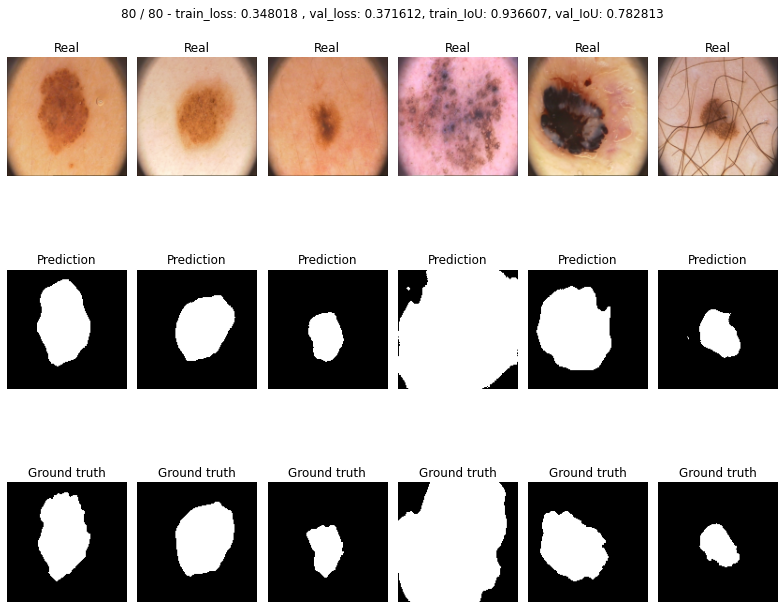

In [26]:
segnet_bce = SegNet().to(device)
seg_bce_hist = train(segnet_bce, bce_loss, max_epochs, data_tr, data_val)

In [27]:
test_scores['SegNet BCE'] = score_model(segnet_bce, iou_pytorch, data_ts)

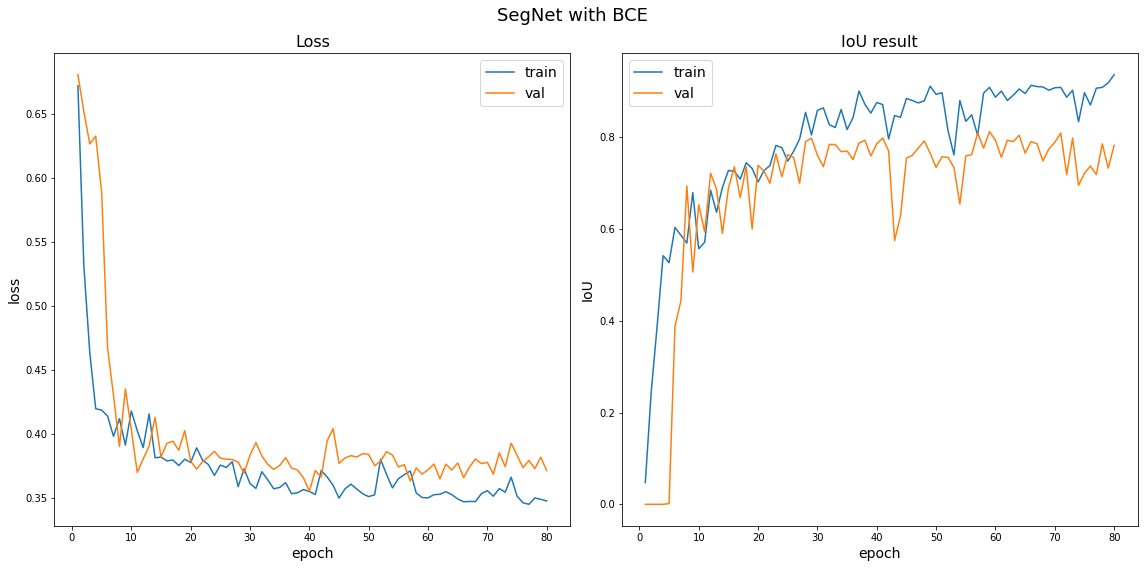

In [28]:
plot_log(seg_bce_hist, "SegNet", "BCE")

In [29]:
clear_gpu(segnet_bce)

#### 4.1.2. Segnet with Dice loss

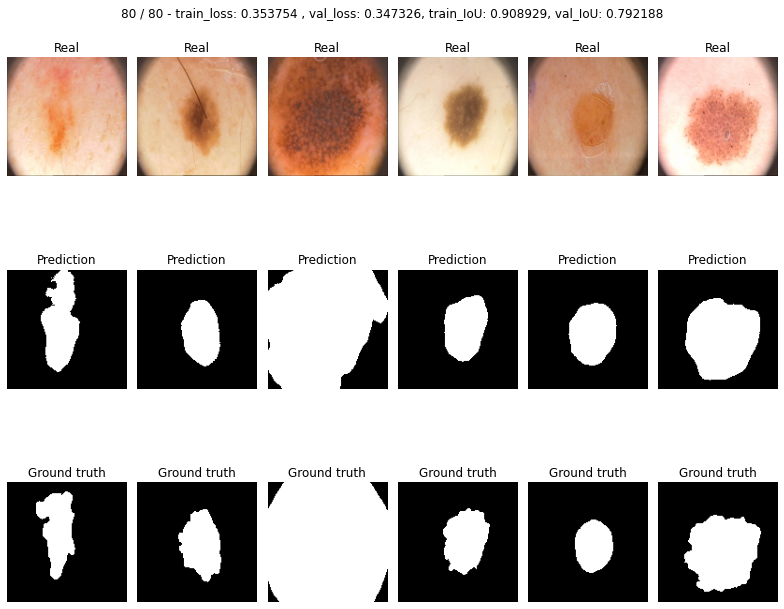

In [30]:
segnet_dice = SegNet().to(device)
seg_dice_hist = train(segnet_dice, dice_loss, max_epochs, data_tr, data_val)

In [31]:
test_scores['SegNet Dice'] = score_model(segnet_dice, iou_pytorch, data_ts)

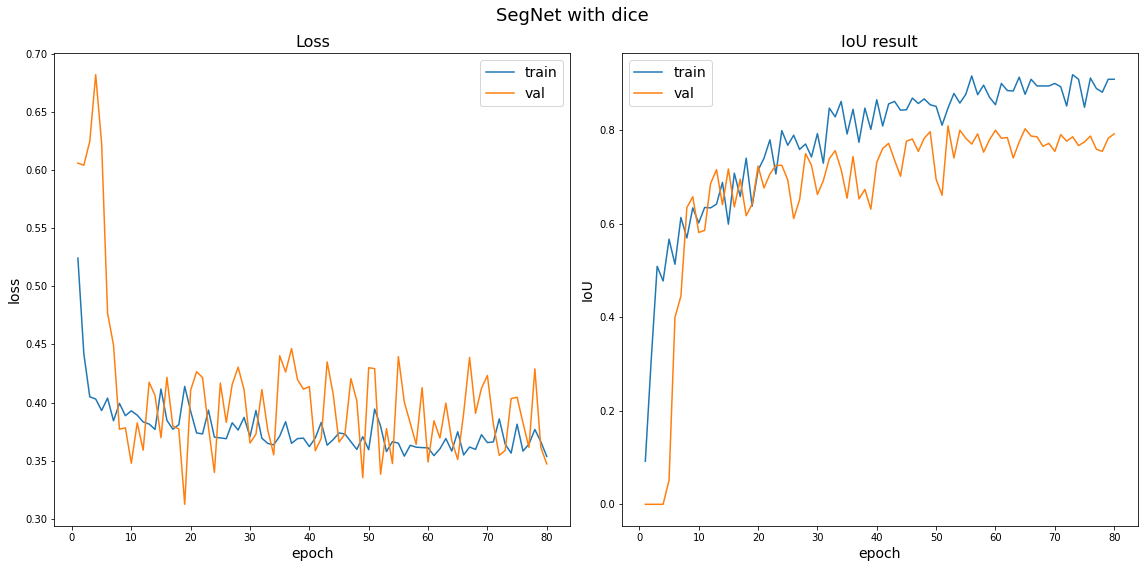

In [32]:
plot_log(seg_dice_hist, "SegNet", "dice")

In [33]:
clear_gpu(segnet_dice)

#### 4.1.3. Segnet with focal loss

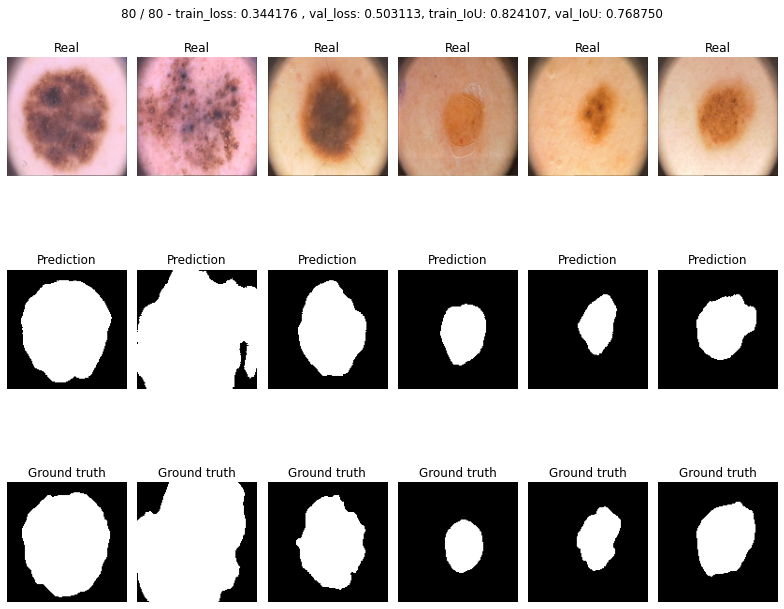

In [34]:
segnet_focal = SegNet().to(device)
seg_focal_hist = train(segnet_focal, focal_loss, max_epochs, data_tr, data_val)

In [35]:
test_scores['SegNet Focal'] = score_model(segnet_focal, iou_pytorch, data_ts)

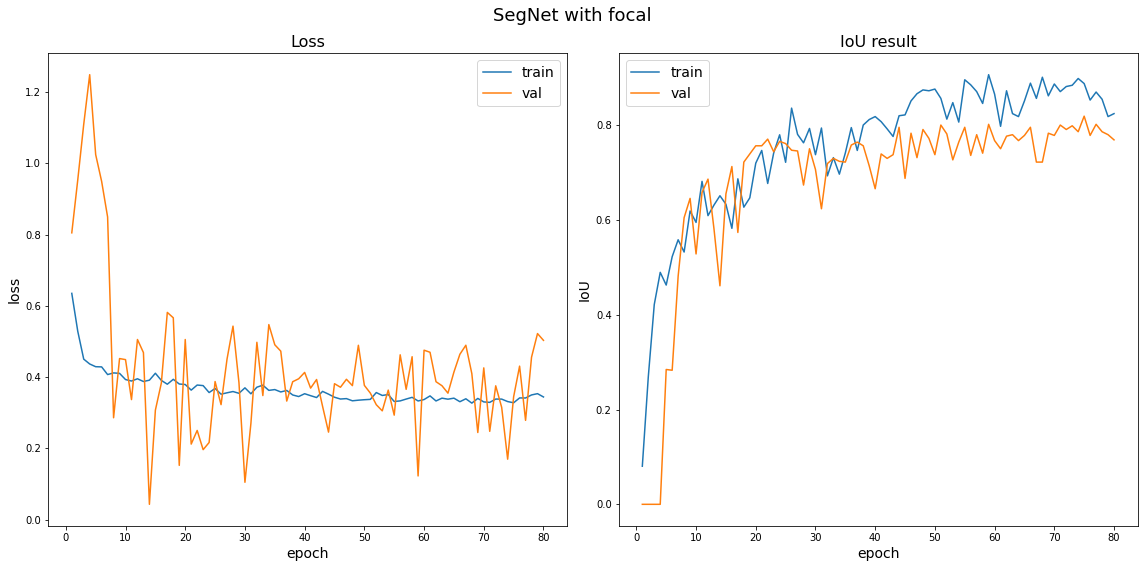

In [36]:
plot_log(seg_focal_hist, "SegNet", "focal")

In [37]:
clear_gpu(segnet_focal)

-----------------------------------------------------------------------------------------

### 4.2. U-Net (2 points)

SegNet architecture is very natural, but it is not the most accurate. Indeed, we first apply pyramid CNN architecture to the original image, which reduces the spatial accuracy of image features. Then, when we reconstruct the image, we cannot correctly reconstruct the pixel positions.

This leads us to the idea of skip connections between convolution layers in encoder and decoder. This architecture is very common for semantic segmentation, and is called [**U-Net**](https://arxiv.org/abs/1505.04597). **Skip connections** at each convolution level helps network not to lose information about features from original input at this level.


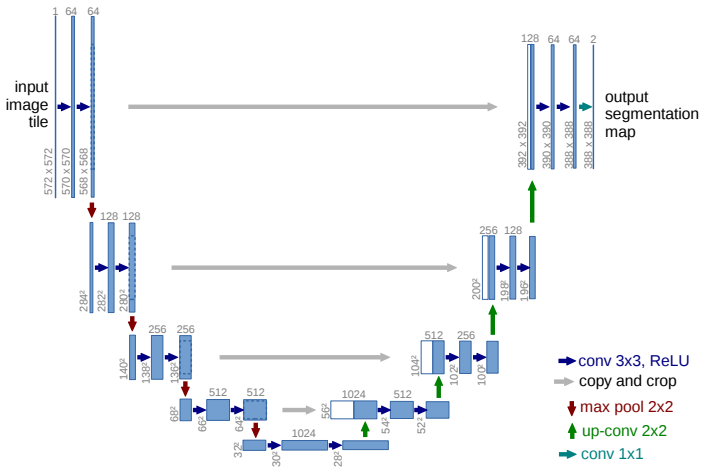

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [38]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel, padding, pooling = 3, 1, 2
        inp, outp, channels = 3, 1, 64
        
        self.enc_conv0 = nn.Sequential(
            EncDec(inp, channels, kernel, padding),
            EncDec(channels, channels, kernel, padding)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True)
        
        self.enc_conv1 = nn.Sequential(
            EncDec(channels, channels*2, kernel, padding),
            EncDec(channels*2, channels*2, kernel, padding)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True)
        
        self.enc_conv2 = nn.Sequential(
            EncDec(channels*2, channels*4, kernel, padding),
            EncDec(channels*4, channels*4, kernel, padding)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True)
        
        self.enc_conv3 = nn.Sequential(
            EncDec(channels*4, channels*8, kernel, padding),
            EncDec(channels*8, channels*8, kernel, padding)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=pooling, stride=pooling, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            EncDec(channels*8, channels*8, kernel, padding),
            EncDec(channels*8, channels*8, kernel, padding)
        )

        # decoder (upsampling)
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
            EncDec(channels*16, channels*8, kernel, padding),
            EncDec(channels*8, channels*4, kernel, padding)
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
            EncDec(channels*8, channels*4, kernel, padding),
            EncDec(channels*4, channels*2, kernel, padding)
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
            EncDec(channels*4, channels*2, kernel, padding),
            EncDec(channels*2, channels, kernel, padding)
        )
        
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            EncDec(channels*2, channels, kernel, padding),
            
            nn.Conv2d(in_channels=channels, out_channels=outp, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_features=outp) 
        )

    def forward(self, x):
        # encoder
        base_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(base_e0)
        base_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(base_e1)
        base_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(base_e2)
        base_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(base_e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(b), base_e3], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3), base_e2], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2), base_e1], dim=1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1), base_e0], dim=1))
        
        return d0

In [39]:
summary(UNet().to(device), (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            EncDec-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            EncDec-8         [-1, 64, 128, 128]               0
         MaxPool2d-9  [[-1, 64, 64, 64], [-1, 64, 64, 64]]               0
           Conv2d-10          [-1, 128, 64, 64]          73,856
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           EncDec-13          [-1, 128, 64, 64]               0
           Conv2d-14        

#### 4.2.1 U-Net with BCE loss

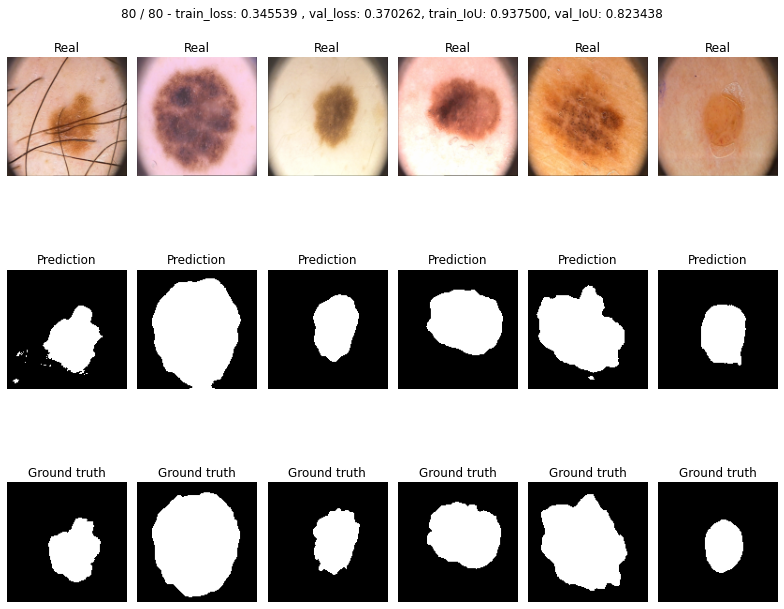

In [40]:
unet_bce = UNet().to(device)
unet_bce_hist = train(unet_bce, bce_loss, max_epochs, data_tr, data_val)

In [41]:
test_scores['UNet BCE'] = score_model(unet_bce, iou_pytorch, data_ts)

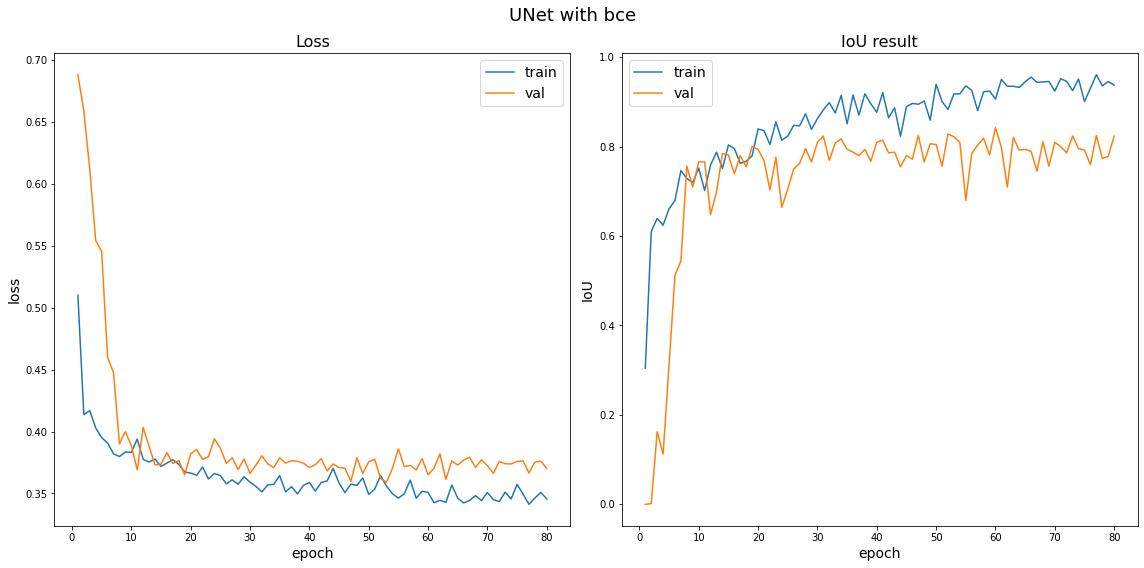

In [42]:
plot_log(unet_bce_hist, "UNet", "bce")

In [43]:
clear_gpu(unet_bce)

#### 4.2.2. UNet with Dice loss

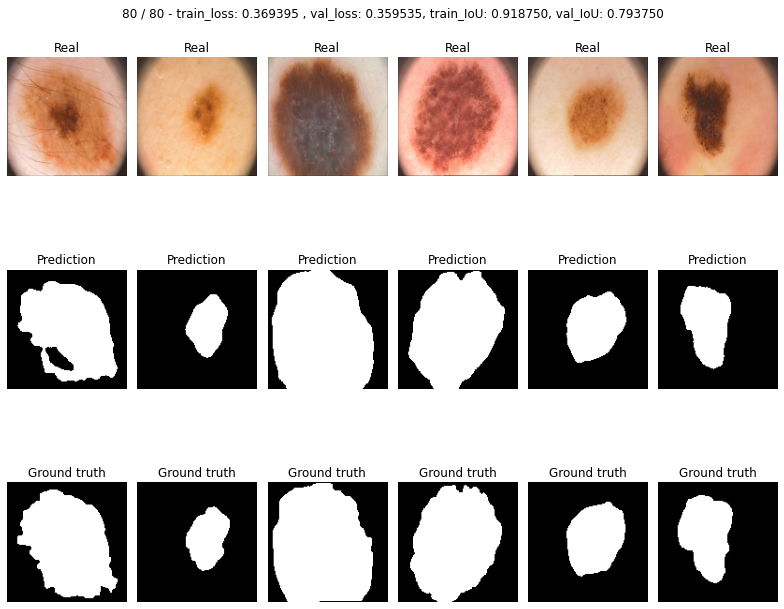

In [44]:
unet_dice = UNet().to(device)
unet_dice_hist = train(unet_dice, dice_loss, max_epochs, data_tr, data_val)

In [45]:
test_scores['UNet Dice'] = score_model(unet_dice, iou_pytorch, data_ts)

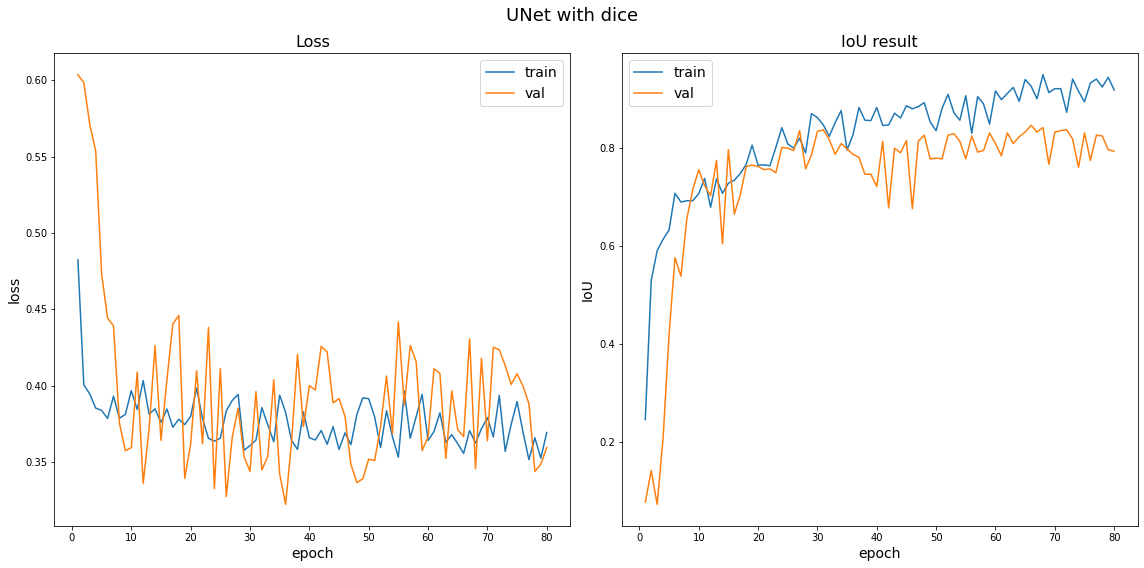

In [46]:
plot_log(unet_dice_hist, "UNet", "dice")

In [47]:
clear_gpu(unet_dice)

#### 4.2.3. UNet with focal loss

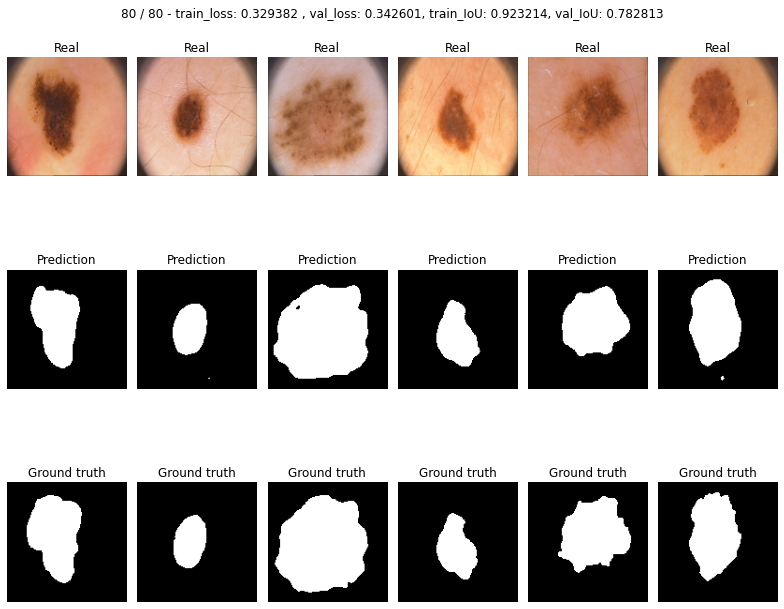

In [48]:
unet_focal = UNet().to(device)
unet_focal_hist = train(unet_focal, focal_loss, max_epochs, data_tr, data_val)

In [49]:
test_scores['UNet Focal'] = score_model(unet_focal, iou_pytorch, data_ts)

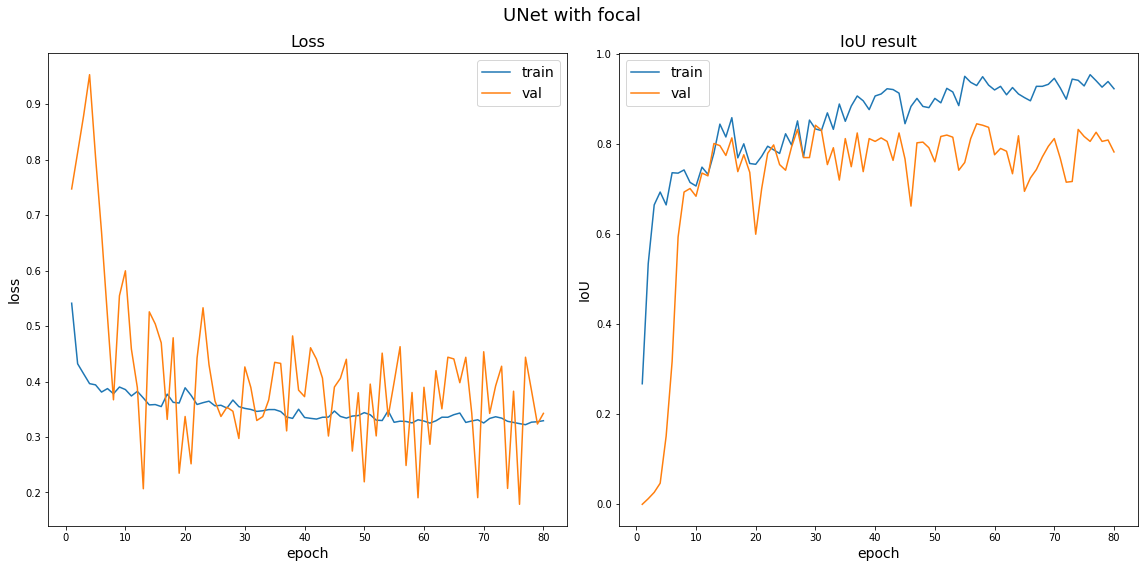

In [50]:
plot_log(unet_focal_hist, "UNet", "focal")

In [51]:
clear_gpu(unet_focal)

## 5. Summary (6 points)

In this paper we investigated various neural network architectures intended for the semantic segmentation. We built a SegNet-like architecture based on MaxPool2d and MaxUnpool2d, and a U-Net architecture based on MaxPool2d and Upsample methods.

Let's define a versatile function to plot losses and scores.

In [52]:
def scores_losses(hist, record):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    x = list(range(1, max_epochs+1))
    k, i = 0, 0
    
    for key, value in histories.items():
        if k == 3:
            i = 1
        ax[i].plot(x, value[record], label=key)
        ax[i].legend(fontsize=12)
        ax[i].set_xlabel("epoch", fontsize = 14)
        ax[i].set_ylabel(record[4:], fontsize=14)
        ax[i].set_title("SegNet", fontsize = 16) if i == 0 else ax[i].set_title("UNet", fontsize = 16)
        k += 1
        
    plt.suptitle(record, fontsize = 18)
    plt.tight_layout()
    plt.show()

In [53]:
histories = {
    'SegNet BCE': seg_bce_hist,
    'SegNet Dice': seg_dice_hist,
    'SegNet Focal': seg_focal_hist,
    'UNet BCE': unet_bce_hist,
    'UNet Dice': unet_dice_hist,
    'UNet Focal': unet_focal_hist
}

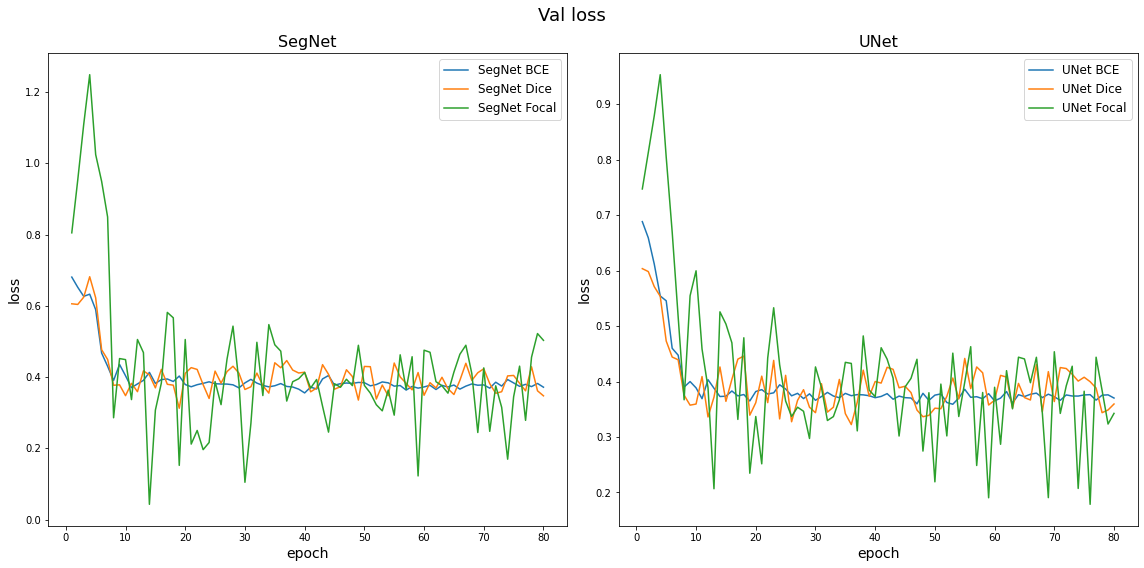

In [54]:
scores_losses(histories, "Val loss")

The plots above show the behavior of the loss functions for SegNet and U-Net. It is worth to note that BCE has the most stable character, while focal loss has a very large spread. However, as the plots below show, such instability hasn't a profound impact on the IoU metric.

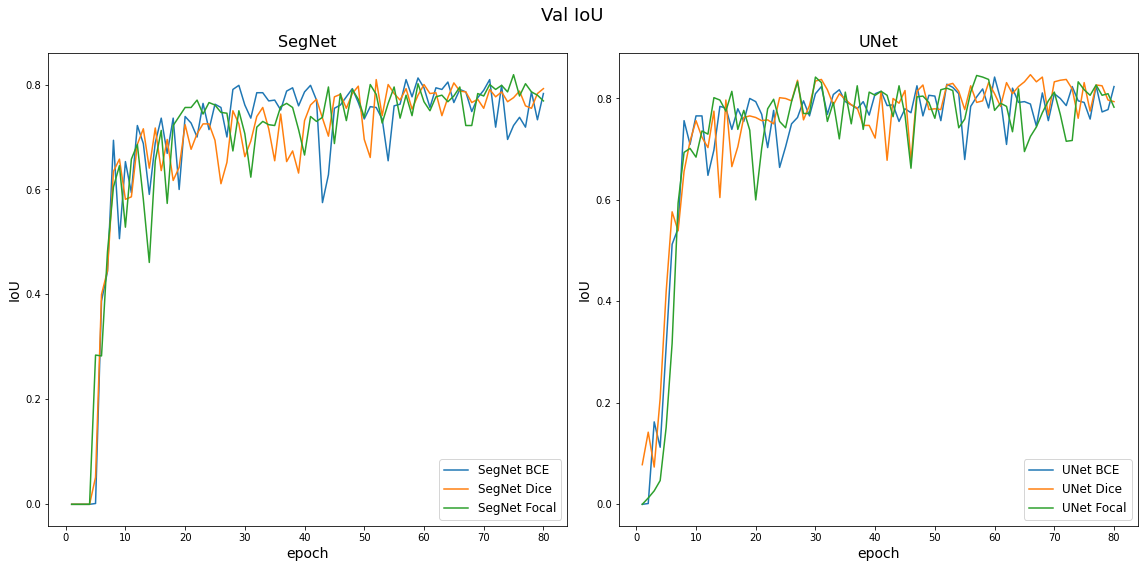

In [55]:
scores_losses(histories, "Val IoU")

As one can see from the following plots, in general U-Net achieves the better results regardless of the selected loss function.

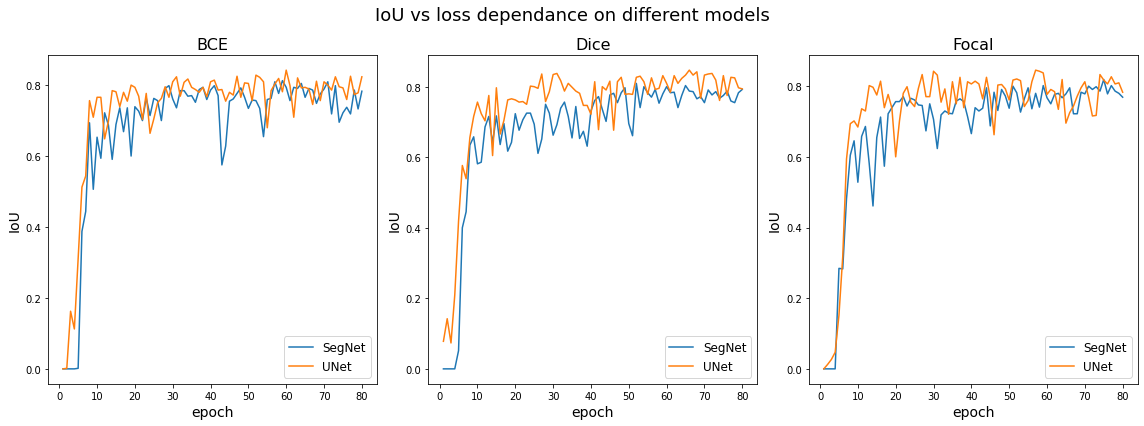

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
x = list(range(1, max_epochs+1))
losses = ['BCE', 'Dice', 'Focal']

for i, var_loss in enumerate(losses):
    ax[i].plot(x, histories['SegNet '+var_loss]['Val IoU'], label='SegNet')
    ax[i].plot(x, histories['UNet '+var_loss]['Val IoU'], label='UNet')
    ax[i].legend(fontsize=12)
    ax[i].set_xlabel("epoch", fontsize = 14)
    ax[i].set_ylabel("IoU", fontsize=14)
    ax[i].set_title(var_loss, fontsize = 16)
       
plt.suptitle("IoU vs loss dependance on different models", fontsize = 18)
plt.tight_layout()
plt.show()

Now let's look at the final scores:

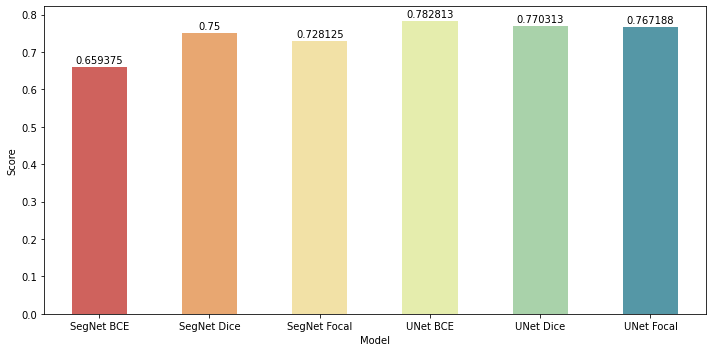

In [57]:
score_df = pd.DataFrame(test_scores.items(), columns=['Model','Score'])
plt.figure(figsize=(10,5))
ax = sns.barplot(data=score_df, x=score_df['Model'], y=score_df['Score'], palette="Spectral", width=0.5)
ax.bar_label(ax.containers[0], padding=2)
plt.tight_layout()
plt.show()

And compare different configurations running time:

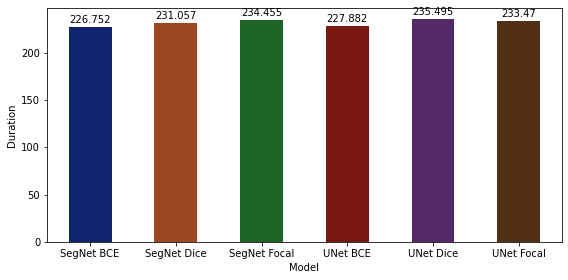

In [58]:
time_log = {}
for key, value in histories.items():
    time_log[key] = value["Duration"]
time_df = pd.DataFrame(time_log.items(), columns=['Model','Duration'])
plt.figure(figsize=(8,4))
ax = sns.barplot(data=time_df, x=time_df['Model'], y=time_df['Duration'], palette="dark", width=0.5)
ax.bar_label(ax.containers[0], padding=2)
plt.tight_layout()
plt.show()

In this experiment we have considered two neural network models: Segnet and U-Net. Each of these models was tested with 3 different types of loss functions, namely: BCE, Dice and Focal while other parameters, like number of epochs, learning rate, optimizer type, etc., were unchanged.

The leadership of the U-Net model is not surprising, although the SegNet lag is not too great. Quite unexpected was the behavior of the focal loss function, which showed significant instability. It should be noted, however, that numerous runs of the models did not reveal an unambiguous dependence of the IoU vs the loss function. It can only be reasonably safe to suggest that U-Net is more advantageous compared to SegNet. Though the IoU comparison diagram shows that SegNet with the Dice loss wins, but in some runs the BCE and the focal loss turned out to be the most beneficial, while the Dice loss tends to give an average result. In contrast, U-Net most commonly shows the best result with Dice loss, although in some cases both focal and BCE come out to be ahead (as it happened in this case).
On the whole, the following conclusions can be drawn:
1. The optimal architecture for solving this problem is U-Net with skip-connections.
2. For SegNet and U-Net the choice of the loss function does not matter much, but if you want to get an optimal result for sure, the preferred loss function is the Dice loss, as BCE and focal can provide both hign and low results.

In terms of computational resources models can be called comparable: SegNet counts 22M parameters, the size of parameters is 85 MB, U-Net counts 17M parameters, the size of parameters is 65 MB. Training time of different configurations is not very different as well.